In [32]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [33]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [34]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [35]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [36]:
engine

Engine(sqlite:///Resources/hawaii.sqlite)

In [37]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)


In [38]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [39]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [40]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [41]:
# find the columns in each table
inspector = inspect(engine)

m_cols = inspector.get_columns('measurement')
print("Measurement")
for c in m_cols:
    print(c['name'], c["type"])
    
s_cols = inspector.get_columns('station')
print("\nStations")
for c in s_cols:
    print(c['name'], c["type"])

Measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

Stations
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [42]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date

('2017-08-23')

In [44]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
dt_recent = dt.datetime.strptime(recent_date[0],'%Y-%m-%d')  
dt_recent = dt.datetime.date(dt_recent)  #adjust so no time
print(f'Most recent date is: {dt_recent}')

# Calculate the date one year from the last date in data set.
one_year_ago = dt_recent.replace(dt_recent.year - 1)
print(f'One year ago is: {one_year_ago}')

# Perform a query to retrieve the data and precipitation scores
m2_cols = (Measurement.date, Measurement.prcp)

prcp_data = session.query(*m2_cols).\
            filter(Measurement.date >= one_year_ago.strftime('%Y-%m-%d')).all()
prcp_data[:5]


Most recent date is: 2017-08-23
One year ago is: 2016-08-23


[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0)]

In [45]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(prcp_data, columns=['date', 'precipitation'])
df.head()

,date,precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [46]:
df.shape

(2230, 2)

In [47]:
# Sort the dataframe by date
df_precip_asc = df.sort_values(by='date',ascending=True)
df_precip_asc.head()

,date,precipitation
0,2016-08-23,0.00
1009,2016-08-23,NaN
1529,2016-08-23,1.79
704,2016-08-23,0.05
361,2016-08-23,0.15


In [48]:
# precipitation has some NaN values  : what should we do with these, remove? because has valid zeros elsewhere
df_precip_asc.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2230 entries, 0 to 2229
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           2230 non-null   object 
 1   precipitation  2021 non-null   float64
dtypes: float64(1), object(1)
memory usage: 52.3+ KB


In [49]:
# clean the dataset, removed rows where no precipitation entry was there, can not assume 0
df_precip_asc_clean = df_precip_asc.dropna(subset=['precipitation'])

In [50]:
df_precip_asc_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2021 entries, 0 to 2229
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           2021 non-null   object 
 1   precipitation  2021 non-null   float64
dtypes: float64(1), object(1)
memory usage: 47.4+ KB


In [51]:
# set index for plotting, (by date, asc and clean)
df_precip_asc_clean.set_index("date", inplace=True)
df_precip_asc_clean[:5]

,precipitation
date,
2016-08-23,0.00
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70


In [52]:
df_precip_asc_clean.shape


(2021, 1)

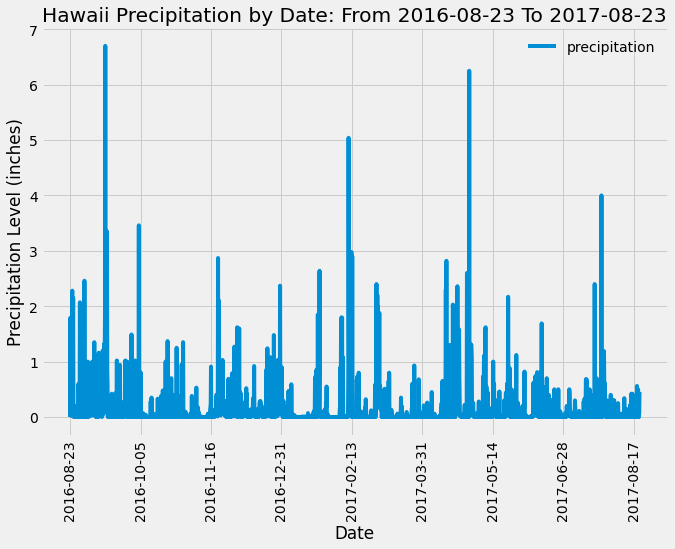

In [62]:
# Use Pandas Plotting with Matplotlib to plot the data
# Using the style that is in above import (not all dates show using bar: overlapping dates) 

df_precip_asc_clean = df_precip_asc_clean.sort_index()
ax = df_precip_asc_clean.plot(kind='line',rot=90,figsize=(10,7));    
ax.set_title(f"Hawaii Precipitation by Date: From {one_year_ago} To {dt_recent}")
ax.set_xlabel("Date")
ax.set_ylabel("Precipitation Level (inches)")

p=ax.legend(loc="upper right", fancybox=True, framealpha=0.1)


In [54]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_precip_asc_clean.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [55]:
# Calculate the total number stations in the dataset
station_count = session.query(func.count(Station.id)).all()  # id is the primary key
station_count

[(9)]

In [56]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
counts_by_station =  session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()
counts_by_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [57]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_station = 'USC00519281'
stats=session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
      filter(Measurement.station == active_station).all()

print(f'Lowest Temperature is {stats[0][0]}')
print(f'Highest Temperature is {stats[0][1]}')
print(f'Average Temperature is {stats[0][2]}')



Lowest Temperature is 54.0
Highest Temperature is 85.0
Average Temperature is 71.66378066378067


In [63]:
# Using the most active station id (the first in counts_by_station)
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data_active_stn = session.query(Measurement.date,Measurement.tobs).\
                        filter(Measurement.station == counts_by_station[0][0]).\
                       filter(Measurement.date >= one_year_ago.strftime('%Y-%m-%d')).all()
temp_data_active_stn[:5]


[('2016-08-23', 77.0),
 ('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0)]

In [64]:
# plot the results as a histogram
# set in dataframe and check for nulls, none found
temp_data_df= pd.DataFrame(temp_data_active_stn)
temp_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352 entries, 0 to 351
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    352 non-null    object 
 1   tobs    352 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.6+ KB


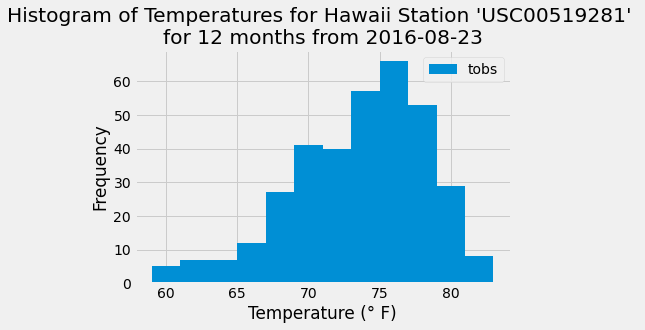

In [65]:
# plot as histogram
degree_sign = u'\N{DEGREE SIGN}'
p=temp_data_df.plot(kind="hist",bins=12)
plt.title(f"Histogram of Temperatures for Hawaii Station '{active_station}' \nfor 12 months from {one_year_ago}")
plt.xlabel(f"Temperature ({degree_sign} F)")
p=plt.ylabel("Frequency")



# Close session

In [66]:
# Close Session
session.close()